In [1]:
%matplotlib inline
import pandas as pd
import sys
import numpy as np
import datetime
import seaborn as sns


In [2]:
from IPython.core.display import HTML
css = open('../Data/style-table.css').read() + open('../Data/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
#imports the raw data in chunks. SQL export could not accomodate one CSV dump

USMTO1 = pd.DataFrame.from_csv('../Data/USMTO1.csv', index_col = False)
USMTO2 = pd.DataFrame.from_csv('../Data/USMTO2.csv', index_col = False)
USMTO3 = pd.DataFrame.from_csv('../Data/USMTO3.csv', index_col = False)
USMTO4 = pd.DataFrame.from_csv('../Data/USMTO4.csv', index_col = False)
USMTO5 = pd.DataFrame.from_csv('../Data/USMTO5.csv', index_col = False)

In [4]:
#imports raw data for S&P 500 values and Industrial Production

SP_500 = pd.DataFrame.from_csv('../Data/SP_500.csv', index_col = False)

In [5]:
#re-combines raw data

USMTO_WHOLE = USMTO1.append(USMTO2).append(USMTO3).append(USMTO4).append(USMTO5)

In [6]:
#merges external data with USMTO data

USMTO_WHOLE = USMTO_WHOLE.merge(SP_500, how='inner', on = ['EntryMonth', 'EntryYear'])

In [7]:
#format order date to datetime to prepare for analysis

USMTO_WHOLE['OrderDateFormatted'] = pd.to_datetime(USMTO_WHOLE.OrderDate)

In [8]:
#format changed date to datetime to prepare for analysis

USMTO_WHOLE['ChangedDateFormatted'] = pd.to_datetime(USMTO_WHOLE.ChangedDate)

In [9]:
#format submit date to datetime to prepare for analysis

USMTO_WHOLE['SubmitDateFormatted'] = pd.to_datetime(USMTO_WHOLE.SubmitDate.fillna(''))

In [10]:
#more formatting to get Order Date at End of Month

USMTO_WHOLE['hyphen'] = "-"

USMTO_WHOLE['OrderDateEOM'] = (USMTO_WHOLE.EntryYear.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.EntryMonth.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.OrderDateFormatted.dt.days_in_month.astype(str))

In [11]:
#format OrderDateEOM to datetime

USMTO_WHOLE['OrderDateEOM'] = pd.to_datetime(USMTO_WHOLE['OrderDateEOM'])


In [12]:
#create column DaysLate which indicates how many days late the order was submitted

USMTO_WHOLE['DaysLate'] = (USMTO_WHOLE['SubmitDateFormatted'] - USMTO_WHOLE['OrderDateEOM']).dt.days - 10

In [13]:
#fill all NaN with "0" -> count=141

USMTO_WHOLE['DaysLate'] = USMTO_WHOLE['DaysLate'].fillna('0')

In [14]:
#cast DaysLate and TotalSale as float64

USMTO_WHOLE['DaysLate'] = pd.to_numeric(USMTO_WHOLE['DaysLate'])
USMTO_WHOLE['TotalSale'] = (USMTO_WHOLE['TotalSale'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [15]:
#drop un-needed columns

USMTO_WHOLE = USMTO_WHOLE.drop('SubmitDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('OrderDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('ChangedDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsCancel', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('CancelOrderID', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('hyphen', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsMatch', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsIgnore', axis=1)

In [16]:
#creates columns IsEmailOne, IsEmailTwo, IsCall indicating when reminders are made for a member to submit

USMTO_WHOLE['IsEmailOne'] = USMTO_WHOLE['DaysLate'] >= 1
USMTO_WHOLE.IsEmailOne = USMTO_WHOLE.IsEmailOne.astype('int')       

USMTO_WHOLE['IsEmailTwo'] = USMTO_WHOLE['DaysLate'] >= 5
USMTO_WHOLE.IsEmailTwo = USMTO_WHOLE.IsEmailTwo.astype('int')    

USMTO_WHOLE['IsCall'] = USMTO_WHOLE['DaysLate'] >= 10
USMTO_WHOLE.IsCall = USMTO_WHOLE.IsCall.astype('int')

USMTO_WHOLE['IsBackfill'] = USMTO_WHOLE['DaysLate'] >= 90
USMTO_WHOLE.IsBackfill = USMTO_WHOLE.IsBackfill.astype('int')

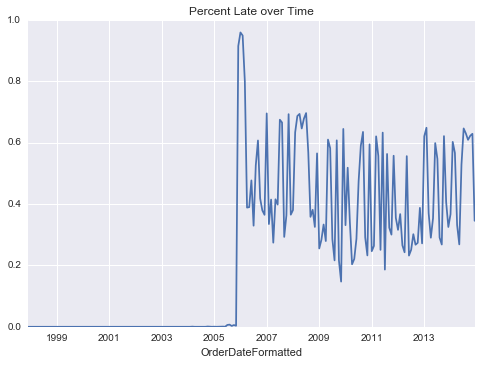

In [17]:
#shows the need to truncate data set

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsEmailOne'].mean().plot(kind = 'line', title = 'Percent Late over Time')

In [18]:
#tosses the former half of data which may not be relevant

USMTO_WHOLE = USMTO_WHOLE[(USMTO_WHOLE.OrderDateFormatted >= '2006-05-01')]

In [19]:
USMTO_WHOLE.columns

Index(['OrderID', 'AAID', 'NAICSID', 'CustomerZipCode', 'ShippingCountryID',
       'ShippingZipCode', 'Units', 'TotalSale', 'CreatedBy', 'CreateDate',
       'ChangedBy', 'IsSubmitted', 'TopCategoryName', 'SubCategory',
       'SubCategoryName', 'Description', 'MachineCode', 'EntryMonth',
       'EntryYear', 'Date', 'Close', 'IP', 'OrderDateFormatted',
       'ChangedDateFormatted', 'SubmitDateFormatted', 'OrderDateEOM',
       'DaysLate', 'IsEmailOne', 'IsEmailTwo', 'IsCall', 'IsBackfill'],
      dtype='object')

In [20]:
USMTO_WHOLE.describe()

,AAID,NAICSID,Units,TotalSale,IsSubmitted,SubCategory,MachineCode,EntryMonth,EntryYear,Close,IP,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill
count,392068.000000,392068.000000,392068.000000,3.920680e+05,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000
mean,101567.163523,451.643654,0.969559,1.511589e+05,0.999612,26.011322,3568.717931,6.866054,2010.319011,1424.766320,100.536678,14.907945,0.440000,0.303307,0.213754,0.031885
std,5267.014327,280.468735,0.234727,2.890960e+05,0.019686,9.751844,384.827128,3.410505,2.604354,282.721568,4.419017,92.569530,0.496388,0.459687,0.409955,0.175694
min,123.000000,1.000000,-1.000000,-9.861252e+06,0.000000,1.000000,3541.205000,1.000000,2006.000000,735.090027,87.412500,-39.000000,0.000000,0.000000,0.000000,0.000000
25%,100132.000000,209.000000,1.000000,4.598594e+04,1.000000,23.000000,3541.540000,4.000000,2008.000000,1267.380005,97.747400,-4.000000,0.000000,0.000000,0.000000,0.000000
50%,100333.000000,248.000000,1.000000,8.190807e+04,1.000000,23.000000,3541.704000,7.000000,2011.000000,1397.910034,101.601600,0.000000,0.000000,0.000000,0.000000,0.000000
75%,100525.000000,749.000000,1.000000,1.650000e+05,1.000000,36.000000,3541.708000,10.000000,2013.000000,1549.380005,104.172000,7.000000,1.000000,1.000000,0.000000,0.000000
max,123556.000000,924.000000,1.000000,4.475133e+07,1.000000,44.000000,9999.999000,12.000000,2014.000000,2067.560059,106.686800,3190.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
#create two new tables, one without outliers (outside 2 stdev), and one without backfillers (defined as submitted later than 100 days - per company definition)

USMTO_NO_SUBMIT_OUTLIERS = USMTO_WHOLE[np.abs(USMTO_WHOLE.DaysLate-USMTO_WHOLE.DaysLate.mean())<=(2*USMTO_WHOLE.DaysLate.std())] 
USMTO_NO_SUBMIT_BACKFILL = USMTO_WHOLE[USMTO_WHOLE.DaysLate <= 90]

#source: http://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe


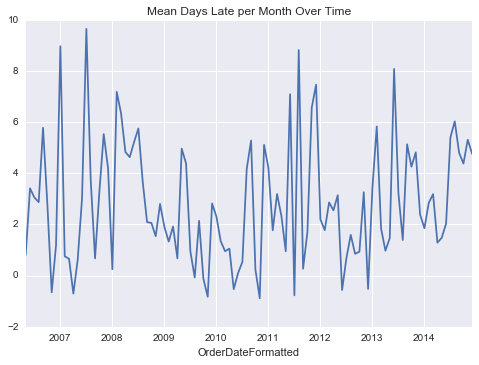

In [22]:
#Plots days late in a time series. Exhibit 1A, to be shared with team.

USMTO_NO_SUBMIT_BACKFILL.groupby(['OrderDateFormatted'])['DaysLate'].mean().plot(kind = 'line', title = 'Mean Days Late per Month Over Time')

In [23]:
#possible causes of change in oscillation
#box and whisker plots - how distribution changed over time
#change of median, edge, etc?
#potential companies that may have joined around 2005


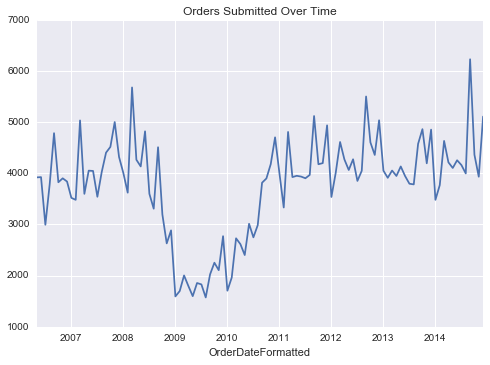

In [24]:
#plot order submission trend. Exhibit 2

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsSubmitted'].sum().plot(kind = 'line', title = 'Orders Submitted Over Time')

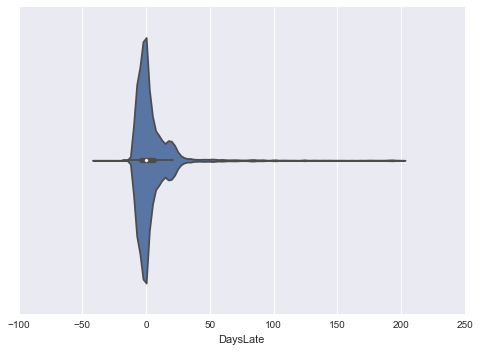

In [25]:
#plots distribution of days late

sns.violinplot(USMTO_NO_SUBMIT_OUTLIERS.DaysLate, title = 'Distribution of Days Late, 1997 to present')


In [26]:
#Creates table by AAID and OrderDateFormatted

AAID_BY_MONTH = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['DaysLate','TotalSale','IsEmailOne', 'IsEmailTwo', 'IsCall', 'IsBackfill','Close','IP'].mean()
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2 = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['Units','TotalSale'].sum()
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH = AAID_BY_MONTH.merge(AAID_BY_MONTH_2, how = 'inner', on = ['AAID','OrderDateFormatted'])
AAID_BY_MONTH['TotalSaleAvg'] = AAID_BY_MONTH['TotalSale_x']
AAID_BY_MONTH['TotalSale'] = AAID_BY_MONTH['TotalSale_y']
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_x', axis = 1)
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_y', axis = 1)
AAID_BY_MONTH.head()

,AAID,OrderDateFormatted,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,Close,IP,Units,TotalSaleAvg,TotalSale
0,123,2007-12-01,522.0,1,1,1,1,1468.359985,105.7256,13,18461.538462,240000.0
1,123,2010-10-01,673.0,1,1,1,1,1183.260010,95.6362,2,100000.000000,200000.0
2,100005,2006-05-01,-5.0,0,0,0,0,1270.089966,102.1531,7,131438.714286,920071.0
3,100005,2006-06-01,1.0,1,0,0,0,1270.199951,102.5220,2,153945.500000,307891.0
4,100005,2006-07-01,-8.0,0,0,0,0,1276.660034,102.5057,11,57971.090909,637682.0


In [27]:
#gets rid of all observations that are backfills
AAID_BY_MONTH_NO_BACKFILL = AAID_BY_MONTH[AAID_BY_MONTH.DaysLate <= 90]


In [28]:
#temporary fill in for adding in feature engineered vars until python script is written

AAID_BY_MONTH_NO_BACKFILL.to_csv('../Data/AAID By Month')
AAID_BY_MONTH_NO_BACKFILL = pd.DataFrame.from_csv('../Data/AAID By Month Edited.csv', index_col = False)
AAID_BY_MONTH_NO_BACKFILL['DaysLateLastThree'] = pd.to_numeric(AAID_BY_MONTH_NO_BACKFILL['DaysLateLastThree'])
AAID_BY_MONTH_NO_BACKFILL['TotalSaleLastThree'] = pd.to_numeric(AAID_BY_MONTH_NO_BACKFILL['TotalSaleLastThree'])
AAID_BY_MONTH_NO_BACKFILL = AAID_BY_MONTH_NO_BACKFILL.fillna(value = 0)


In [29]:
AAID_BY_MONTH_NO_BACKFILL.dtypes

AAID                      int64
OrderDateFormatted       object
DaysLate                  int64
IsEmailOne                int64
IsEmailTwo                int64
IsCall                    int64
IsBackfill                int64
Close                   float64
Units                     int64
TotalSaleAvg            float64
TotalSale               float64
Three_MMA_Late          float64
Three_MMA_SalesTrend    float64
DaysLateLastThree       float64
TotalSaleLastThree      float64
DaysLateLast            float64
IP                      float64
UnitsLast               float64
TotalSaleAvgLast        float64
IsCallLast              float64
dtype: object

In [30]:
#create column "Three MMA Late" - which models the average of the past three month's lateness for each company

#AAID_BY_MONTH_NO_BACKFILL['Three_MMA_Late'] = AAID_BY_MONTH_NO_BACKFILL.DaysLate.ewm(span=3).mean()
#AAID_BY_MONTH_NO_BACKFILL.groupby(['OrderDateFormatted'])['Three_MMA_Late'].mean().plot(kind = 'line')


In [31]:
#AAID_BY_MONTH_NO_BACKFILL['Three_MMA_SalesTrend'] = AAID_BY_MONTH_NO_BACKFILL.TotalSale.ewm(span=3).mean()
#AAID_BY_MONTH_NO_BACKFILL.groupby(['OrderDateFormatted'])['Three_MMA_SalesTrend'].sum().plot(kind = 'line')

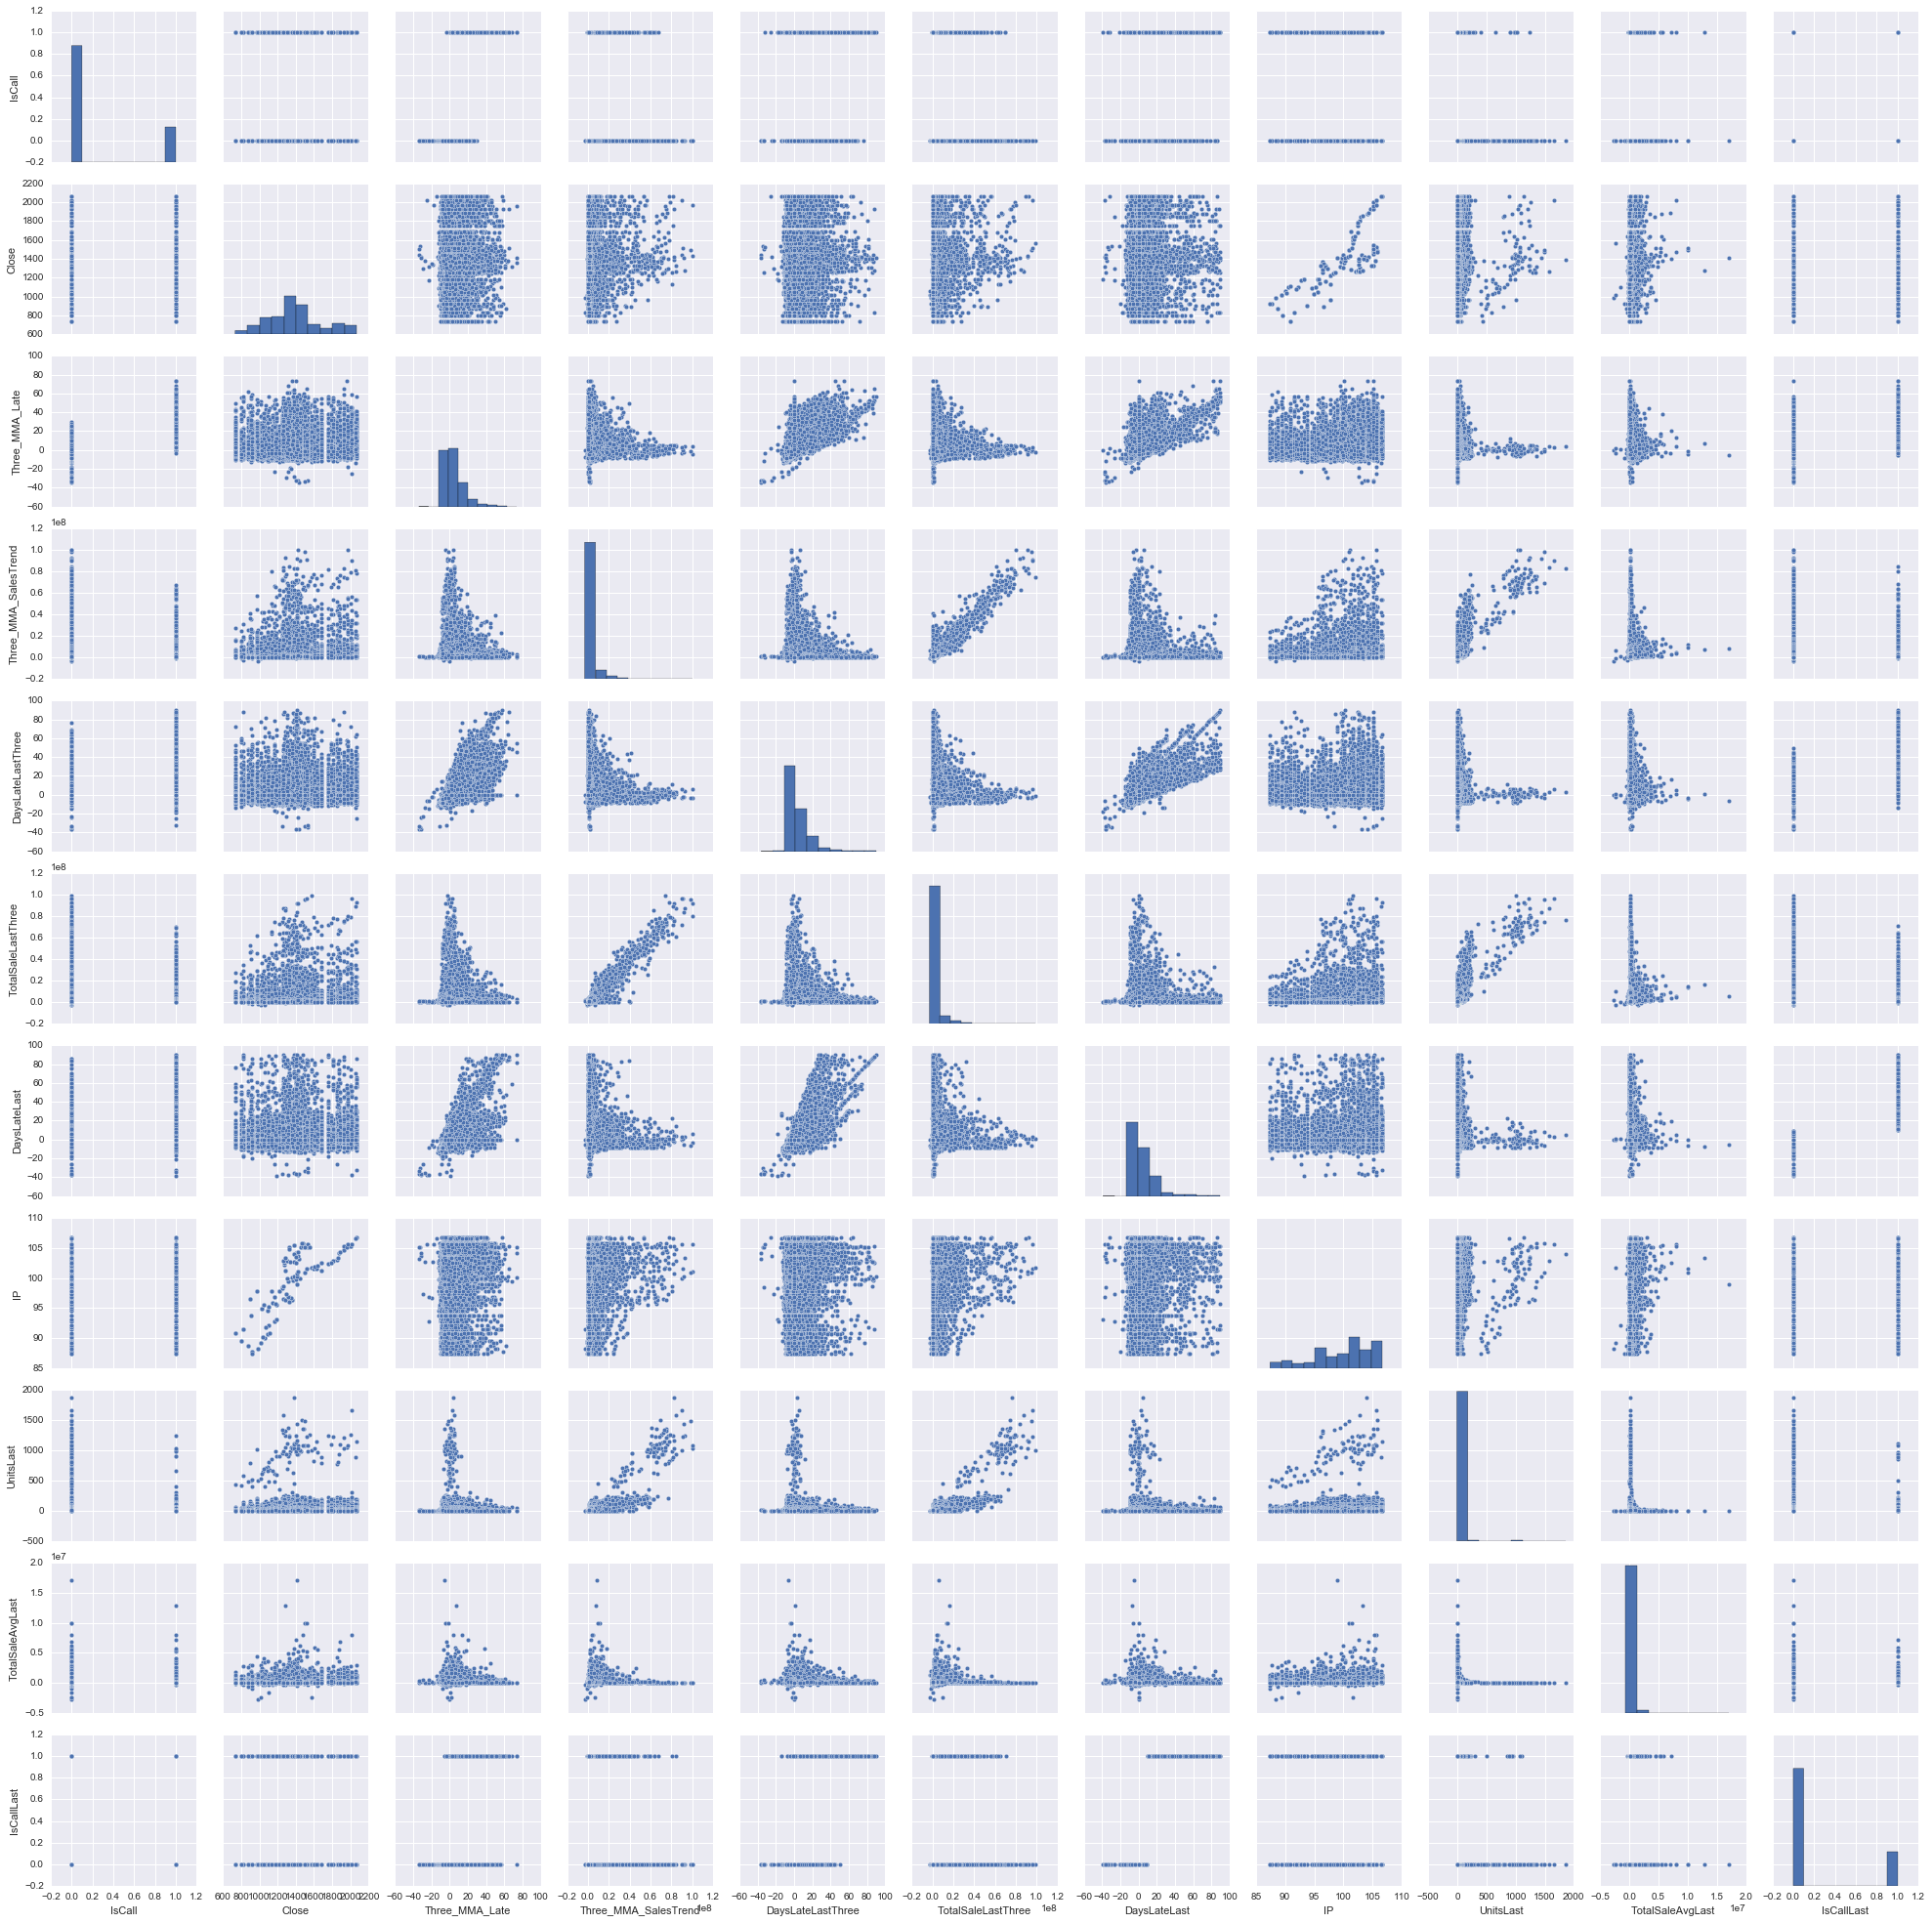

In [32]:
#scatter matrix identifying key features - target excluded

PAIRPLOT2 = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT2 = PAIRPLOT2.drop('AAID', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OrderDateFormatted', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailOne', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailTwo', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsBackfill', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('DaysLate', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSaleAvg', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Units', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSale', axis = 1)

sns.pairplot(PAIRPLOT2)

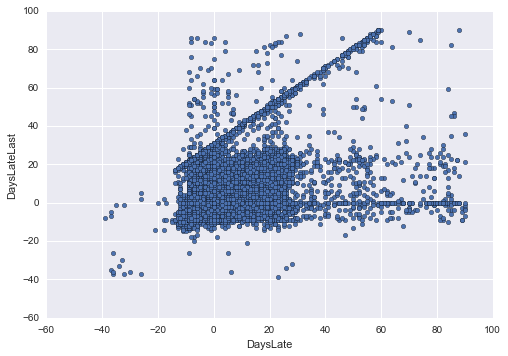

In [33]:
#DaysLate Last vs Days Late (suspicious line - business reason for this, not data error)

AAID_BY_MONTH_NO_BACKFILL.plot.scatter('DaysLate','DaysLateLast')

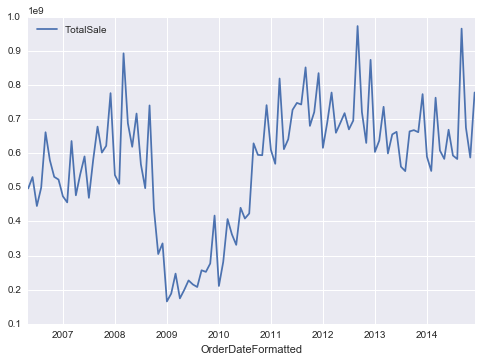

In [34]:
#average sales over time

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).sum()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='TotalSale')

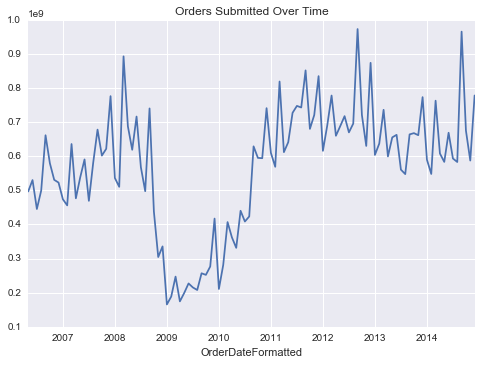

In [35]:
#plot of orders submitted over time

USMTO_WHOLE.groupby(['OrderDateFormatted'])['TotalSale'].sum().plot(kind = 'line', title = 'Orders Submitted Over Time')

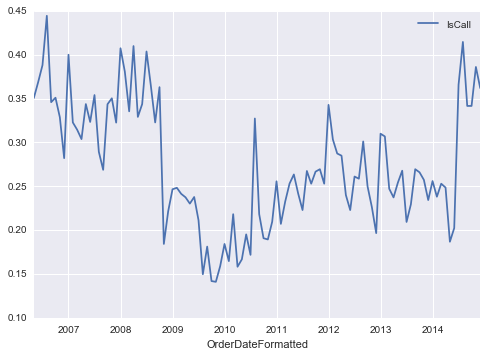

In [36]:
#percentage of company by month who needed to be called

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsCall')

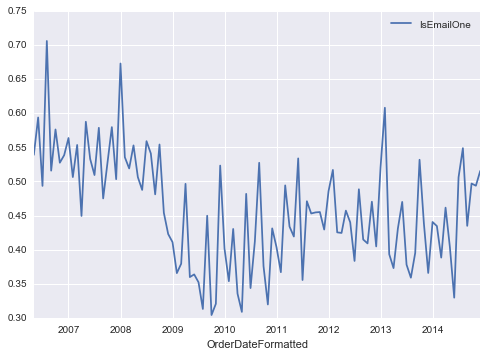

In [37]:
#percentage of company by month who needed to have first email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailOne')

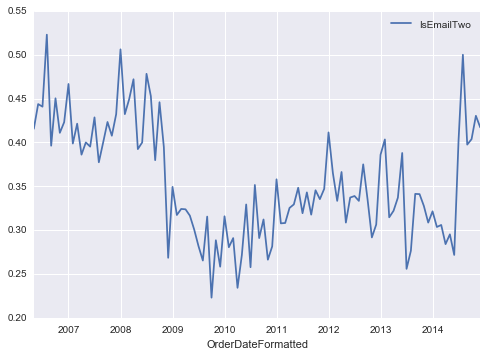

In [38]:
#percentage of company by month who needed to have second email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailTwo')

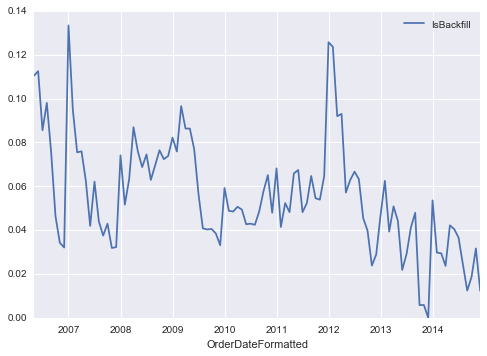

In [39]:
#percentage of company by month who backfilled

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsBackfill')

In [40]:
#prep for correlation matrix - target included. also the dataframe for machine learning algorithms

PAIRPLOT2 = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT2 = PAIRPLOT2.drop('AAID', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OrderDateFormatted', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailOne', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailTwo', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsBackfill', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('DaysLate', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSaleAvg', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Units', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSale', axis = 1)

corr2 = PAIRPLOT2.corr(method = 'pearson')

In [41]:
PAIRPLOT2.columns

Index(['IsCall', 'Close', 'Three_MMA_Late', 'Three_MMA_SalesTrend',
       'DaysLateLastThree', 'TotalSaleLastThree', 'DaysLateLast', 'IP',
       'UnitsLast', 'TotalSaleAvgLast', 'IsCallLast'],
      dtype='object')

In [44]:
#Class Distribution

AAID_BY_MONTH_NO_BACKFILL.groupby('IsCall').size()

IsCall
0    12321
1     3719
dtype: int64

In [45]:
#Skew of Attributes

PAIRPLOT2.skew()

IsCall                   1.270878
Close                    0.369165
Three_MMA_Late           1.733397
Three_MMA_SalesTrend     5.899049
DaysLateLastThree        2.282692
TotalSaleLastThree       5.921180
DaysLateLast             2.516090
IP                      -0.724223
UnitsLast               11.925780
TotalSaleAvgLast        12.234455
IsCallLast               1.313808
dtype: float64

In [46]:
PAIRPLOT2.corr()

,IsCall,Close,Three_MMA_Late,Three_MMA_SalesTrend,DaysLateLastThree,TotalSaleLastThree,DaysLateLast,IP,UnitsLast,TotalSaleAvgLast,IsCallLast
IsCall,1.000000,0.077764,0.757631,-0.003002,0.468473,-0.008318,0.449449,0.122950,-0.028395,0.030896,0.461439
Close,0.077764,1.000000,0.072659,0.064332,0.055856,0.063488,0.060961,0.789642,0.036185,0.028630,0.068478
Three_MMA_Late,0.757631,0.072659,1.000000,0.002579,0.773360,-0.004209,0.747065,0.124476,-0.020709,0.022627,0.618408
Three_MMA_SalesTrend,-0.003002,0.064332,0.002579,1.000000,-0.003181,0.965752,0.003329,0.083472,0.782593,0.101729,-0.002014
DaysLateLastThree,0.468473,0.055856,0.773360,-0.003181,1.000000,0.000280,0.805167,0.100720,-0.018297,0.026482,0.669605
TotalSaleLastThree,-0.008318,0.063488,-0.004209,0.965752,0.000280,1.000000,0.002877,0.080767,0.788520,0.112716,0.000166
DaysLateLast,0.449449,0.060961,0.747065,0.003329,0.805167,0.002877,1.000000,0.095675,-0.012965,0.023663,0.782168
IP,0.122950,0.789642,0.124476,0.083472,0.100720,0.080767,0.095675,1.000000,0.045953,0.030492,0.108129
UnitsLast,-0.028395,0.036185,-0.020709,0.782593,-0.018297,0.788520,-0.012965,0.045953,1.000000,-0.053644,-0.023003
TotalSaleAvgLast,0.030896,0.028630,0.022627,0.101729,0.026482,0.112716,0.023663,0.030492,-0.053644,1.000000,0.032428


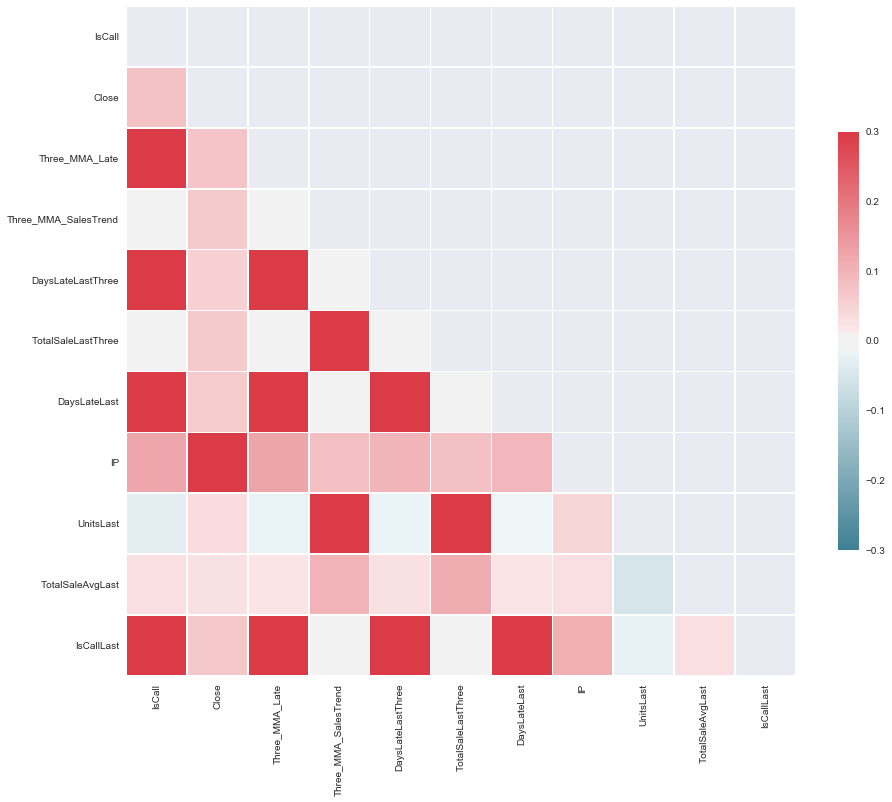

In [47]:
#Correlation Matrix Plot
import matplotlib.pyplot as plt

# Generate a mask for the upper triangle
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


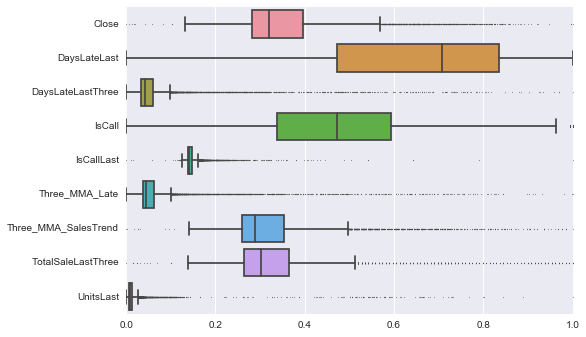

In [97]:
#rescales all data to be between 0 and 1 and readies it for further processing - in progress

import scipy

from sklearn.preprocessing import MinMaxScaler

array = PAIRPLOT2.values
# separate array into input and output components
X = array[:,1:14]
Y = array[:,0]
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X)

rescaledX3 = rescaledX.reshape((-1,8))

rescaledX3 = pd.DataFrame({'IsCall':rescaledX[:,0],'Close':rescaledX[:,1],'Three_MMA_Late':rescaledX[:,2],'Three_MMA_SalesTrend':rescaledX[:,3],'DaysLateLastThree':rescaledX[:,4],'TotalSaleLastThree':rescaledX[:,5],'DaysLateLast':rescaledX[:,6],'UnitsLast':rescaledX[:,7],'IsCallLast':rescaledX[:,8]})
sns.boxplot(data = rescaledX3, orient = 'h', fliersize = '1')

In [100]:
PAIRPLOT2.describe()

,IsCall,Close,Three_MMA_Late,Three_MMA_SalesTrend,DaysLateLastThree,TotalSaleLastThree,DaysLateLast,IP,UnitsLast,TotalSaleAvgLast,IsCallLast
count,16040.000000,16040.000000,16040.000000,1.604000e+04,16040.000000,1.604000e+04,16040.000000,16040.000000,16040.000000,1.604000e+04,16040.000000
mean,0.231858,1388.674964,3.850868,3.549592e+06,3.884102,3.478841e+06,3.716584,99.706184,22.592706,2.327278e+05,0.225499
std,0.422032,295.474676,11.102938,7.671811e+06,12.092413,7.664880e+06,14.192845,4.945777,83.979435,4.163287e+05,0.417923
min,0.000000,735.090027,-33.954242,-3.252481e+06,-36.333333,-2.828082e+06,-39.000000,87.412500,-7.000000,-2.639510e+06,0.000000
25%,0.000000,1186.689941,-3.662053,6.290349e+05,-3.666667,5.792411e+05,-5.000000,96.495900,3.000000,7.265131e+04,0.000000
50%,0.000000,1365.680054,0.374053,1.436333e+06,0.000000,1.368689e+06,0.000000,101.038200,8.000000,1.377012e+05,0.000000
75%,0.000000,1526.750000,8.635307,3.237936e+06,8.333333,3.182756e+06,8.000000,103.526300,19.000000,2.596626e+05,0.000000
max,1.000000,2067.560059,73.537079,1.001146e+08,90.000000,9.903093e+07,90.000000,106.686800,1867.000000,1.700000e+07,1.000000


In [98]:
rescaledX3.head()

,Close,DaysLateLast,DaysLateLastThree,IsCall,IsCallLast,Three_MMA_Late,Three_MMA_SalesTrend,TotalSaleLastThree,UnitsLast
0,0.269364,0.764780,0.027765,0.401510,0.134398,0.040366,0.287599,0.302326,0.003735
1,0.306576,0.783920,0.030787,0.401592,0.141091,0.036418,0.248021,0.263566,0.007471
2,0.269364,0.783074,0.032406,0.406441,0.142237,0.037113,0.271768,0.310078,0.004803
3,0.368596,0.800195,0.033870,0.426824,0.137350,0.034441,0.255937,0.240310,0.009605
4,0.355792,0.789507,0.031075,0.482450,0.137758,0.033436,0.308707,0.418605,0.004269


In [51]:
#relationship between last month's days late and this month's call

#rescaledX3.plot.scatter('DaysLateLast','IsCall')

In [54]:
#columns which correspond to feature selection output

PAIRPLOT2.columns

Index(['IsCall', 'Close', 'Three_MMA_Late', 'Three_MMA_SalesTrend',
       'DaysLateLastThree', 'TotalSaleLastThree', 'DaysLateLast', 'IP',
       'UnitsLast', 'TotalSaleAvgLast', 'IsCallLast'],
      dtype='object')

In [57]:
# Feature Importance with Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]

# feature extraction
model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

[ 0.0255429   0.53787707  0.02743163  0.10201953  0.02595659  0.05013547
  0.02846229  0.02577112  0.02751107  0.14929233]


In [58]:
# Feature Extraction with RFE 

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# load data

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 4)
fit = rfe.fit(X, Y)
print("Num Features: " , fit.n_features_)
print("Selected Features: " , fit.support_)
print("Feature Ranking: " , fit.ranking_)

Num Features:  4
Selected Features:  [False  True False  True False  True False False False  True]
Feature Ranking:  [3 1 7 1 6 1 2 4 5 1]


In [59]:
#Feature Extraction with PCA - in progress

from sklearn.decomposition import PCA
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
# feature extraction
pca = PCA(n_components=4)
fit = pca.fit(X)
# summarize components
print("Explained Variance: ", fit.explained_variance_ratio_)
print(fit.components_)

Explained Variance:  [  9.81446731e-01   1.71017078e-02   1.45156084e-03   7.37962114e-10]
[[  1.77172628e-06  -8.41704606e-10   7.07430733e-01  -1.64269237e-09
    7.06770237e-01   4.13712334e-09   3.81054717e-08   6.18895142e-06
    4.19397990e-03  -3.60678161e-11]
 [ -6.52283161e-07  -2.02150387e-07  -7.06752361e-01   1.13542795e-07
    7.07332968e-01  -1.63499948e-08  -3.56856592e-08   1.31266422e-06
    1.34600384e-02   2.49094269e-09]
 [  1.56812845e-05   6.46282346e-07   6.54661438e-03   7.66541757e-07
   -1.24861499e-02   8.08770159e-07   2.64869198e-07  -2.87312441e-05
    9.99900613e-01   3.27133106e-08]
 [  9.99896551e-01   2.73337383e-03  -1.80659544e-06   2.29104171e-03
   -5.75115232e-07   2.92170238e-03   1.31810129e-02  -3.44708232e-03
   -1.57850040e-05   9.67862127e-05]]


In [60]:
#we end up using all features

In [61]:
#import ML models

from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


In [101]:
#test different types of models

array = PAIRPLOT2.values
X = array[:,1:14].astype(float)
Y = array[:,0]
validation_size = 0.33
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y,
test_size=validation_size, random_state=seed)
num_folds = 5
num_instances = len(X_train)
seed = 7
scoring = 'accuracy'
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC())) - causes code to hang
results = []
names = []
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = (name, cv_results.mean(),cv_results.std())
    print(msg)


('LR', 0.77033311329228304, 0.0049488182208948638)
('LDA', 0.94221065503695611, 0.006593245577885494)
('KNN', 0.72873591827458961, 0.0099025956459634131)
('CART', 0.96128734836105489, 0.0071596557047824043)
('NB', 0.76623822870561753, 0.0037752355957407281)


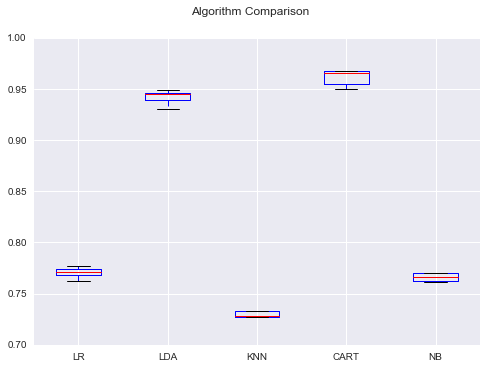

In [102]:
#distribution of models, accuracy and std dev

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [104]:
#classification report with best model (Decision Trees)

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = LinearDiscriminantAnalysis()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.95      0.99      0.97      4043
        1.0       0.95      0.81      0.88      1251

avg / total       0.95      0.95      0.95      5294



In [82]:
# Cross Validation Classification LogLoss (smaller logloss better with 0 as perfect logloss)


from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:8]
Y = array[:,0]
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = LinearDiscriminantAnalysis()
scoring = 'log_loss'
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring = scoring)
print("Logloss: ", results.mean(), "      Std Dev: ", results.std()*100.0)

Logloss:  -0.12338741619       Std Dev:  1.73510950668


In [83]:
# Cross Validation Classification with Area Under the Curve (Between 0.5 and 1 indicates good model)


from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:8]
Y = array[:,0]
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = LinearDiscriminantAnalysis()
scoring = 'roc_auc'
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring = scoring)
print("AUC: ", results.mean(), "      Std Dev: ", results.std()*100.0)

AUC:  0.993960296832       Std Dev:  0.152687182758


In [67]:
#APPENDIX AS FOLLOWS: (works in progress)

In [68]:
#cols to create:

#3 MMA company sales
#3 MMA lateness
# s&p 500 
machine tool mix
#prior month late days
# scatter matrix



SyntaxError: invalid syntax (<ipython-input-68-8bd383b2e483>, line 6)

In [ ]:
#attempts to map which AAIDs submitted over what dates

AAIDs = pd.DataFrame.from_csv('AAIDs.csv', index_col = False)

In [ ]:
AAIDs = AAIDs.fillna('')

In [ ]:
AAIDs

In [ ]:
#plots distribution who received a first email, over all time

USMTO_WHOLE.groupby('OrderDateFormatted')['IsEmailOne'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsEmailTwo'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsCall'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsBackfill'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE